In [1]:
import pandas  as pd
import os
import numpy as np
from tqdm import tqdm
%matplotlib inline

### load dbSNP VCF annotation

In [2]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
%time vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(str)

<string>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 4.47 s, sys: 652 ms, total: 5.12 s
Wall time: 2.21 s


In [3]:
vcfDf['VP_Int']=vcfDf['Annot'].str.extract('VP=(0x\w+)',expand=False).apply(lambda Str:int(Str,16))

### identify and categorize sequencing runs based on cell lines and primary tumor tissues

In [4]:
#8 mins
%time allSRS_S=pd.read_pickle("/cellar/users/btsui/Data/SRA/DUMP/allSRS.pickle.gz")

CPU times: user 7min 24s, sys: 4min 1s, total: 11min 25s
Wall time: 11min 25s


In [5]:
allSRS_S.head()

ERS018283  SUBMITTER_ID          0073_93-sc-2011-01-25-1067919
           Strain                                      0073/93
           Sample Description                                 
ERS166165  TITLE                         Staphylococcus aureus
           SCIENTIFIC_NAME               Staphylococcus aureus
dtype: object

In [6]:
allSRS_S.index.names=['SRS_ID','attribute']

In [7]:
attribute_array=allSRS_S.index.get_level_values('attribute')

In [8]:
%time primary_cancer_m=allSRS_S.str.contains('primary.*tumor|cancer',case=False)

CPU times: user 57.5 s, sys: 3.49 s, total: 1min
Wall time: 57.9 s


In [9]:
celline_m=attribute_array.str.contains('cell[_ ]line')

In [10]:
cancer_m=allSRS_S.str.contains('oma',case=False)

In [11]:
#cancer:0.0029
cancer_m.mean()

0.005281996023668792

In [12]:
tissueS=allSRS_S[primary_cancer_m]
cellLineS=allSRS_S[celline_m]

In [13]:
primary_cancer_m.sum()

147036

In [14]:
celline_m.sum()

112887

In [15]:
sra_dump_df=pd.read_pickle("/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle")

In [16]:
sra_dump_df.head()

,Member_Name,Experiment,Sample,Study,Spots,Bases,Status,ScientificName,LibraryStrategy,LibraryLayout,...,proj_accession_Published,proj_accession_Received,proj_accession_Type,proj_accession_Center,proj_accession_Visibility,proj_accession_Loaded,proj_accession_ReplacedBy,new_ScientificName,Run_db,Run_digits
Run,,,,,,,,,,,,,,,,,,,,,
SRR2401865,default,SRX1244330,SRS1068422,-,2800.0,1416405.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401865
SRR2401866,default,SRX1244331,SRS1068421,-,5082.0,2563605.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401866
SRR2401867,default,SRX1244332,SRS1068420,-,6169.0,3175528.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401867
SRR2401868,default,SRX1244333,SRS1068419,-,8102.0,4266915.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401868
SRR2401869,default,SRX1244334,SRS1068418,-,4971.0,2519200.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-20,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401869


In [17]:
sra_dump_df['SampleType']=np.nan

In [18]:
sra_dump_df.loc[sra_dump_df['Sample'].isin(tissueS.index.get_level_values('SRS_ID')),
    'SampleType']='tissue'

In [19]:

sra_dump_df.loc[sra_dump_df['Sample'].isin(cellLineS.index.get_level_values('SRS_ID')),
    'SampleType']='cell line'

In [20]:
sra_dump_df['SampleType'].value_counts()

cell line    158904
tissue        59287
Name: SampleType, dtype: int64

In [21]:
sra_dump_df.head()

,Member_Name,Experiment,Sample,Study,Spots,Bases,Status,ScientificName,LibraryStrategy,LibraryLayout,...,proj_accession_Received,proj_accession_Type,proj_accession_Center,proj_accession_Visibility,proj_accession_Loaded,proj_accession_ReplacedBy,new_ScientificName,Run_db,Run_digits,SampleType
Run,,,,,,,,,,,,,,,,,,,,,
SRR2401865,default,SRX1244330,SRS1068422,-,2800.0,1416405.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401865,NaN
SRR2401866,default,SRX1244331,SRS1068421,-,5082.0,2563605.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401866,NaN
SRR2401867,default,SRX1244332,SRS1068420,-,6169.0,3175528.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401867,NaN
SRR2401868,default,SRX1244333,SRS1068419,-,8102.0,4266915.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401868,NaN
SRR2401869,default,SRX1244334,SRS1068418,-,4971.0,2519200.0,live,soil_metagenome,AMPLICON,SINGLE,...,2015-09-15,RUN,SUB1095135,public,1,-,soil_metagenome,SRR,2401869,NaN


In [22]:
reindexedMetaDf=sra_dump_df[sra_dump_df['SampleType'].notnull()].set_index(['Run_db','Run_digits'])
runsRequireExtractionI=reindexedMetaDf.index

In [23]:
#sra_dump_df.head()

### extract sites with alternative alleles

In [24]:
#from right to left
nth_bit=6
vcfDf['somatic']=(vcfDf['VP_Int']%(2**(nth_bit-1))).astype(bool).values

In [25]:
myG=['Chr','Pos']
refS=vcfDf.drop_duplicates(myG).set_index(myG)['RefBase']

In [26]:
vcfDf['specificSNP']=vcfDf['AltBase'].str.contains('^[ACGT]$')

In [27]:
#check if braf is located within germline
myG=['Run_db','Run_digits',u'Chr', u'Pos',u'base']
#vcfDf.head()

In [28]:
vcfDf.head()

,Chr,Pos,RsId,RefBase,AltBase,,,Annot,VP_Int,somatic,specificSNP
0,1,14727,rs1045587,G,A,.,.,RS=1045587;RSPOS=14727;RV;dbSNPBuildID=117;SSR...,1547614017554423799187767552,False,True
1,1,630825,rs9783068,T,C,.,.,RS=9783068;RSPOS=630825;dbSNPBuildID=119;SSR=1...,1547613980660935651768664384,False,True
2,1,630833,rs9701099,C,T,.,.,RS=9701099;RSPOS=630833;dbSNPBuildID=119;SSR=1...,1547613980660935651768664384,False,True
3,1,817186,rs3094315,G,A,.,.,RS=3094315;RSPOS=817186;RV;dbSNPBuildID=103;SS...,1548822906480573393185800449,True,True
4,1,833068,rs12562034,G,A,.,.,RS=12562034;RSPOS=833068;dbSNPBuildID=120;SSR=...,1548823017161040034332147968,False,True


In [31]:
tmp_dir='/nrnb/users/btsui/Data/all_seq/tmp_chunks/'


### load in SRRs with data

In [32]:
inFnameS=pd.Series(os.listdir(tmp_dir)).sample(n=3,random_state=1)

In [33]:
#inFname=inFnameS.iloc[0]
#cell line
myL=[]
for inFname in tqdm(inFnameS):
    tmpDf=pd.read_pickle(tmp_dir+inFname)
    tmpDf2=tmpDf.reset_index().drop_duplicates()
    tmpI=tmpDf2.set_index(['Run_db','Run_digits']).index
    m_inSelected=tmpI.isin(runsRequireExtractionI)
    tmpDf3=tmpDf2[m_inSelected]
    tmpDf3['base']=tmpDf3.base.astype(str)
    myL.append(tmpDf3)

  0%|          | 0/3 [00:00<?, ?it/s]/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
 33%|███▎      | 1/3 [00:56<01:52, 56.48s/it]/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
 67%|██████▋   | 2/3 [01:17<00:38, 38.76s/it]/cellar/users/btsui/anaconda3/lib/python3.6/site-packag

In [34]:
len(myL)

3

In [35]:
tmpDf2=pd.concat(myL,axis=0)

In [36]:
srrI=tmpDf2.set_index(['Run_db','Run_digits']).index
tmpDf2['SampleType']=reindexedMetaDf.loc[srrI,'SampleType'].values

In [37]:
#g_l=['SampleType','Run_db','Run_digits','Chr','Pos','base']
tmpDf2=tmpDf2.drop_duplicates(['SampleType','Run_db','Run_digits','Chr','Pos','base'])

In [38]:
tmpDf2.head()

features,Run_db,Run_digits,Chr,Pos,base,ReadDepth,AverageBaseQuality,SampleType
1267754,SRR,372679,1,630825,T,5,38,cell line
1267755,SRR,372679,1,630833,C,6,40,cell line
1267756,SRR,372679,1,842133,G,7,34,cell line
1267757,SRR,372679,1,1045751,A,10,40,cell line
1267758,SRR,372679,1,1050763,G,6,36,cell line


In [39]:
#tmpDf2.head().dtypes
myI=tmpDf2.set_index(['Chr','Pos','base']).index
refI=vcfDf.set_index(['Chr','Pos','RefBase']).index
m_inRef=myI.isin(refI)

In [40]:
baseQualityThreshold=30
m_baseQual=tmpDf2['AverageBaseQuality']>=baseQualityThreshold

In [41]:
tmpDf3=tmpDf2#[m_baseQual]#.drop_duplicates(g_l)

In [42]:
g_l=['SampleType','Run_db','Run_digits','Chr','Pos']

In [43]:
#tmpDf2_sub=tmpDf2[m_inRef&m_baseQual]

refAlleleS=tmpDf3[(m_inRef)&m_baseQual].groupby(g_l)['ReadDepth'].first()

In [44]:
#refAlleleS

In [45]:
len(m_inRef),len(m_baseQual),tmpDf3.shape

(8710073, 8710073, (8710073, 8))

In [46]:
%time tmpDf6=tmpDf3[(~m_inRef)&m_baseQual]
altAlleleS=tmpDf6.groupby(g_l)['ReadDepth'].sum()

CPU times: user 2.92 s, sys: 300 ms, total: 3.22 s
Wall time: 223 ms


In [47]:
altAlleleS.head()

SampleType  Run_db  Run_digits  Chr  Pos    
cell line   ERR     244845      1    1046551    1.0
                                     1163041    1.0
                                     1707458    1.0
                                     2352457    1.0
                                     4657331    1.0
Name: ReadDepth, dtype: float64

In [48]:
refAlleleS.head()

SampleType  Run_db  Run_digits  Chr  Pos    
cell line   ERR     244845      1    14727      1
                                     630825     7
                                     630833     8
                                     1045172    2
                                     1045177    2
Name: ReadDepth, dtype: uint16

In [49]:
%time raw_allelic_df=pd.DataFrame({'ref_rd':refAlleleS,'alt_rd':altAlleleS})

CPU times: user 16min 36s, sys: 3min 57s, total: 20min 33s
Wall time: 2min 39s


In [50]:
allelic_df=raw_allelic_df[raw_allelic_df.notnull().all(axis=1)]

In [51]:
refAlleleS.head()

SampleType  Run_db  Run_digits  Chr  Pos    
cell line   ERR     244845      1    14727      1
                                     630825     7
                                     630833     8
                                     1045172    2
                                     1045177    2
Name: ReadDepth, dtype: uint16

In [52]:
allelic_df.fillna(0,inplace=True)

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [53]:
#allelic_df

In [54]:
allelic_df['alt_fraction']=allelic_df['alt_rd']/(allelic_df['ref_rd']+allelic_df['alt_rd'])

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
#allelic_df

In [56]:
tmpDf5=allelic_df.reset_index().set_index(['Chr','Pos'])

In [57]:
#tmpDf3.head()

In [58]:
somaticI=vcfDf[vcfDf['somatic']&vcfDf['specificSNP']].set_index(['Chr','Pos']).index
germline_I=vcfDf[(~vcfDf['somatic'])&vcfDf['specificSNP']].set_index(['Chr','Pos']).index

In [59]:
import matplotlib.pyplot as plt

In [60]:
siteRdS=(tmpDf5['ref_rd']+tmpDf5['alt_rd'])

In [61]:
#tmpDf5[]

In [62]:
m_allelic_f=(tmpDf5['alt_fraction']>=0.0)&(siteRdS>10)&(tmpDf5['alt_fraction']<=1.0)


In [63]:
#tmpDf5

In [64]:
#tmpDf5['alt_fraction'].value_counts()

In [65]:
tmpDf5['SampleType'].value_counts()

cell line    334039
tissue        48186
Name: SampleType, dtype: int64

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


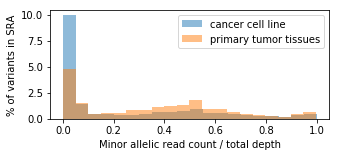

In [74]:

fig,ax=plt.subplots(figsize=(5,2))

m_somatic=tmpDf5.index.isin(somaticI)

tmpDf_cl=tmpDf5[m_allelic_f&(tmpDf5.SampleType=='cell line')]
tmpDf_cl['alt_fraction'].hist(ax=ax,alpha=0.5,bins=20,label='cancer cell line',normed=True)#.plot(kind='KDE',ax=ax,label='Known somatic sites')

tmpDf_tissue=tmpDf5[m_allelic_f&(tmpDf5.SampleType=='tissue')]
tmpDf_tissue['alt_fraction'].hist(ax=ax,alpha=0.5,bins=20,label='primary tumor tissues',normed=True)#.plot(kind='KDE',ax=ax,label='Known somatic sites')

ax.set_ylabel('% of variants in SRA')
#ax.set_xlim([-0.1,1.1])
ax.set_xlabel('Minor allelic read count / total depth')
ax.legend()
ax.grid(False)

In [75]:
from scipy import stats

In [76]:
stats.mannwhitneyu(tmpDf_cl['alt_fraction'],tmpDf_tissue['alt_fraction'],)

MannwhitneyuResult(statistic=1540481506.0, pvalue=0.0)

In [69]:
asdasd

NameError: name 'asdasd' is not defined

In [ ]:
tmpDf3

In [ ]:
%time tmpDf3[tmpDf3.index.isin(germline_I)&m_allelic_f][\
    'alt_fraction'].sample(n=10000).plot(kind='KDE',ax=ax,label='germline')

In [ ]:
fig.legend()

In [ ]:
ax.set_ylabel('Density of variants')
ax.set_xlabel('Allelic frequency')

In [ ]:
fig

In [ ]:
rdS=allelic_df[['ref_rd','alt_rd']].sum(axis=1)

In [ ]:
allelic_df_filtered=allelic_df[rdS>=5]

In [ ]:
allelic_df_filtered.groupby(level=0).first()

In [ ]:
tmpDf10=allelic_df_filtered.reset_index()

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#allelic_df_filtered

In [ ]:
myLabel='Known germline \nmutations'
#myLabel='Known somatic \nmutations'
fig,ax=plt.subplots()

germ_alt_S=allelic_df_filtered.loc[myLabel]['alt_fraction']#.hist()
m=(germ_alt_S>0)&(germ_alt_S<1)
germ_alt_S.hist(alpha=0.3,ax=ax,label=myLabel,normed=True)

myLabel='Known somatic \nmutations'
germ_alt_S=allelic_df_filtered.loc[myLabel]['alt_fraction']#.hist()
print (len(germ_alt_S))
m=(germ_alt_S>0)&(germ_alt_S<1)
germ_alt_S.hist(alpha=0.3,ax=ax,label=myLabel,normed=True)
ax.legend()


In [ ]:
allelic_df_filtered

In [ ]:
allelic_df_filtered.loc['Known somatic \nmutations']['alt_fraction'].hist()

In [ ]:
sns.boxplot(data=tmpDf10,x='ref base',y='alt_fraction')


In [ ]:
allelic_df_filtered['alt_fraction'].hist(bins=30)

In [ ]:
%time tmpDf=tmpDf2.drop_duplicates(['Run_db','Run_digits','base']).set_index(['Run_db','Run_digits','base','ref base'])['ReadDepth'].unstack()

In [ ]:
tmpDf

In [ ]:
#rs78378222 and rs1042522 

In [ ]:
#inFname=inFnameS.iloc[1]
def inF(inFname):
    tmpDf=pd.read_pickle(tmp_dir+inFname)

    tmpDf2=tmpDf.reset_index().drop_duplicates()



    #tmpDf2.head().dtypes

    myI=tmpDf2.set_index(['Chr','Pos','base']).index

    m_inRef=myI.isin(refI)
    m_somatic=myI.isin(somaticI)
    m_germline=myI.isin(germline_I)
    tmpDf2.loc[m_inRef,'ref base']='Reference alleles'
    tmpDf2.loc[m_somatic,'ref base']='Known somatic \nmutations'
    tmpDf2.loc[m_germline,'ref base']='Known germline \nmutations'
    #tmpDf2['ref base'].fillna('Known germline \nmutations',inplace=True)

    tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2

    tmpS=tmpDf2.groupby(['ref base','base','Run_db','Run_digits'])[varToPlot].sum()
    return tmpS


In [ ]:
from multiprocessing import Pool

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
with Pool(48) as p:
    tmpSL=list(tqdm(p.imap(inF,inFnameS.values),
                   total=len(inFnameS)))

In [ ]:
mergedS=np.log10(pd.concat(tmpSL,axis=0)+1)

In [ ]:
#%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


In [ ]:
fig,ax=plt.subplots(figsize=(7,3))
ax=sns.violinplot(data=mergedS.reset_index(),
               x='ref base',y=varToPlot,ax=ax)
#ax.set_xticklabels()
#at least 2 reads
#each dot is a variant
ax.set_ylabel('log10 ( # of sequencing runs in SRA with support for variants)' )
#ax.set_xlabel()
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.pdf')
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.png',dpi=300)

In [ ]:
#fig.savefig('../Results/')

In [ ]:
#ax=mergedS[False].hist()

In [ ]:
### make sure the data read in will have all the results
inFname=inFnameS.iloc[1]

tmpDf=pd.read_pickle(tmp_dir+inFname)

tmpDf2=tmpDf.reset_index().drop_duplicates()



#tmpDf2.head().dtypes

myI=tmpDf2.set_index(['Chr','Pos','base']).index

m_inRef=myI.isin(refI)

tmpDf2.loc[m_inRef,'ref base']=True

tmpDf2['ref base'].fillna(False,inplace=True)

tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2

tmpS=tmpDf2.groupby(['ref base','base','Run_db','Run_digits'])['pass rd'].sum()

In [ ]:
#tmpS

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig,ax=plt.subplots()
g=tmpDf2[tmpDf2['ref base']].groupby(['base','Run_db','Run_digits'])['pass rd']
countS1=np.log10(g.sum())
countS1.hist(normed=True,ax=ax,label='Reference allele')

g=tmpDf2[~tmpDf2['ref base']].groupby(['Run_db','Run_digits'])['pass rd']
countS2=np.log10(g.sum())
countS2.hist(normed=True,ax=ax,alpha=0.4,label='Alternative allele')
#'log10 ( number of sites with at least 2 reads)' , '% of SRA sequencing runs'
ax.set_ylabel('% of SRA sequencing runs')
ax.legend()
ax.set_xlabel('log10 ( number of sites with at least 2 reads)')
ax.grid(False)

In [ ]:
from scipy import stats

In [ ]:
stats.wilcoxon(countS1,countS2)

In [ ]:
type(myI),

In [ ]:
m_inRef.mean()

In [ ]:
tmpDf=pd.read_pickle(tmp_dir+inFnameS.iloc[0])

In [ ]:
tmpDf

In [ ]:
attribVC=attribute_array.value_counts()#.head(n=50)

In [ ]:
attribVC[attribVC.index.str.contains('cell',case=False)]

In [ ]:
attribVC.idnex